In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Gradient Boosted Regression Trees
http://blog.datarobot.com/gradient-boosted-regression-trees

Complete Guide to Parameter Tuning in Gradient Boosting (GBM) in Python<br>
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

# Gradient Boosted Regression Trees

Gradient Boosted Regression Trees (GBRT) or shorter Gradient Boosting is a flexible non-parametric statistical learning technique for classification and regression. 

This notebook shows how to use GBRT in [scikit-learn](http://scikit-learn.org), an easy-to-use, general-purpose toolbox for machine learning in Python. We will start by giving a brief introduction to scikit-learn and its GBRT interface. The bulk of the tutorial will show how to use GBRT in practise and discuss important issues such as regularization, tuning, and model interpretation.

Scikit-learn provides two estimators for gradient boosting: ``GradientBoostingClassifier`` and ``GradientBoostingRegressor``, both are located in the ``sklearn.ensemble`` package.

In [2]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [3]:
GradientBoostingRegressor?

Estimators support arguments to control the fitting behaviour -- these arguments are often called _hyperparameters_. Among the most important ones for GBRT are:

  * number of regression trees (``n_estimators``)
  * depth of each individual tree (``max_depth``)
  * loss function (``loss``)
  * learning rate (``learning_rate``)

For example if you want to fit a regression model with 100 trees of depth 3 using least-squares:

In [4]:
est = GradientBoostingRegressor(n_estimators=100, max_depth=3, loss='ls')

You can find extensive documentation on the [scikit-learn website](http://scikit-learn.org/dev/modules/ensemble.html#gradient-tree-boosting) or in the docstring of the estimator - in IPython simply use ``GradientBoostingRegressor?`` to view the docstring.

During the fitting process, the state of the estimator is stored in instance attributes that have a trailing underscore ('\_'). For example, the sequence of regression trees (``sklearn.tree.DecisionTreeRegressor`` objects) is stored in ``est.estimators_``.

Here is an self-contained example that shows how to fit a ``GradientBoostingClassifier`` to a synthetic dataset (taken from [Hastie et al., _The Elements of Statistical Learning_, Ed2]):

# Example:GradientBoostingClassifier

In [5]:
from sklearn.datasets import make_hastie_10_2
from sklearn.cross_validation import train_test_split

# generate synthetic data from ESLII - Example 10.2
X, y = make_hastie_10_2(n_samples=5000)
X_train, X_test, y_train, y_test = train_test_split(X, y)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
print(X.shape)
print(set(y))

(5000L, 10L)
set([1.0, -1.0])


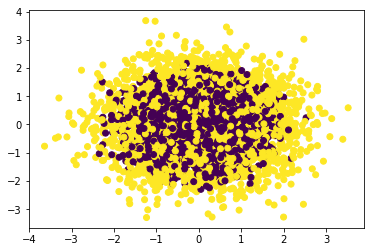

In [7]:
plt.scatter(X[:,0],X[:,1],c=y)

In [8]:
# fit estimator
est = GradientBoostingClassifier(n_estimators=200, max_depth=3)
est.fit(X_train, y_train)

# predict class labels
pred = est.predict(X_test)

# score on test data (accuracy)
acc = est.score(X_test, y_test)
print('ACC: %.4f' % acc)

# predict class probabilities
est.predict_proba(X_test)[0]

ACC: 0.9144


array([ 0.02540846,  0.97459154])

## Gradient Boosting in Practise

Most of the challenges in applying GBRT successfully in practise can be illustrated in the context of a simple curve fitting example. Below you can see a regression problem with one feature ``x`` and the corresponding response ``y``. We draw 100 training data points by picking an ``x`` coordinate uniformly at random, evaluating the ground truth (sinoid function; light blue line) and then adding some random gaussian noise. In addition to the 100 training points (blue) we also draw 100 test data points (red) which we will use the evaluate our approximation.

In [9]:
def ground_truth(x):
    """Ground truth -- function to approximate"""
    return x * np.sin(x) + np.sin(2 * x)

def gen_data(n_samples=200):
    """generate training and testing data"""
    np.random.seed(13)
    x = np.random.uniform(0, 10, size=n_samples)
    x.sort()
    y = ground_truth(x) + 0.75 * np.random.normal(size=n_samples)
    train_mask = np.random.randint(0, 2, size=n_samples).astype(np.bool)
    #create the training dataset
    x_train, y_train = x[train_mask, np.newaxis], y[train_mask]
    #create the testing dataset
    x_test, y_test = x[~train_mask, np.newaxis], y[~train_mask]
    return x_train, x_test, y_train, y_test
X_train, X_test, y_train, y_test = gen_data(200)

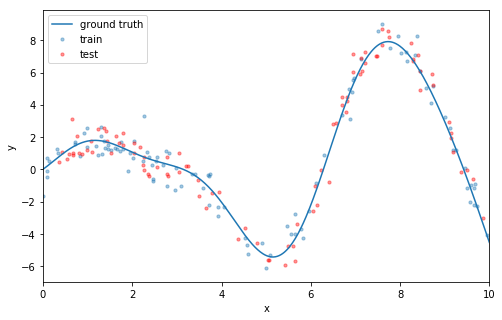

In [10]:
# plot ground truth
x_plot = np.linspace(0, 10, 500)

def plot_data(figsize=(16, 10)):
    fig = plt.figure(figsize=figsize)
    plt.plot(x_plot, ground_truth(x_plot), alpha=1, label='ground truth')
    
    
    # plot training and testing data
    plt.scatter(X_train, y_train, s=10, alpha=0.4,label="train")
    plt.scatter(X_test, y_test, s=10, alpha=0.4, label = "test",color='red')
    plt.xlim((0, 10))
    
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend()

plot_data(figsize=(8, 5))
plt.show() 

If you fit an individual regression tree to the above data you get a piece-wise constant approximation. The deeper you grow the tree the more constant segments you can accomodate thus the more variance you can capture.

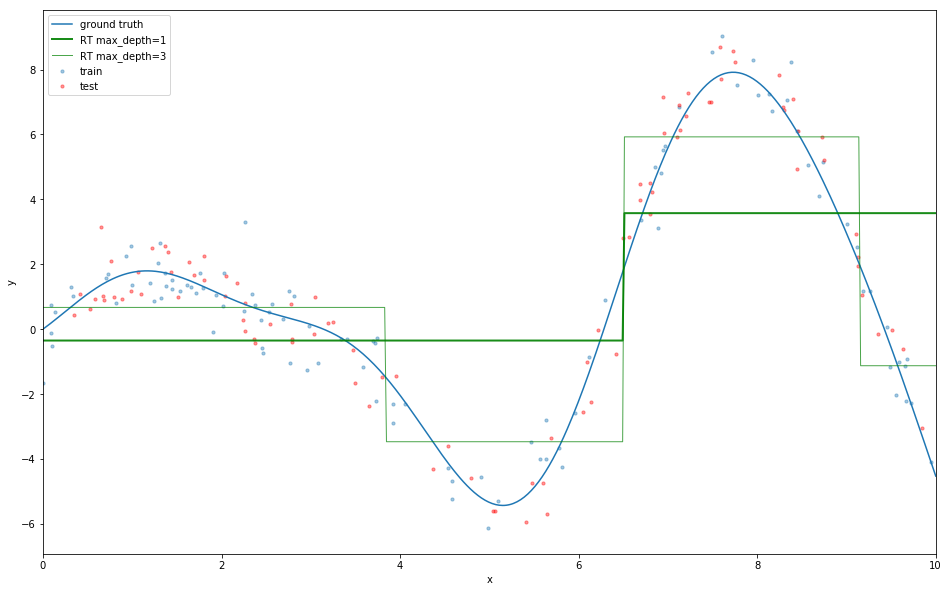

In [11]:
from sklearn.tree import DecisionTreeRegressor
plot_data()
est = DecisionTreeRegressor(max_depth=1).fit(X_train.reshape(-1, 1), y_train)
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]),
         label='RT max_depth=1', color='g', alpha=0.9, linewidth=2)

est = DecisionTreeRegressor(max_depth=2).fit(X_train.reshape(-1, 1), y_train)
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]),
         label='RT max_depth=3', color='g', alpha=0.7, linewidth=1)

# plt.plot(x_plot,staged_pred[100],
#         label="GradientBoostingRegressor",color = "r",alpha = 0.8,linewidth = 1)

plt.legend(loc='upper left')
plt.show()

Now lets fit a gradient boosting model to the training data and lets see how the approximation progresses as we add more and more trees. The scikit-learn gradient boosting estimators allow you to evaluate the prediction of a model as a function of the number of trees via the ``staged_(predict|predict_proba)`` methods. The method return a generator that iterates over the predictions as you add more and more trees.

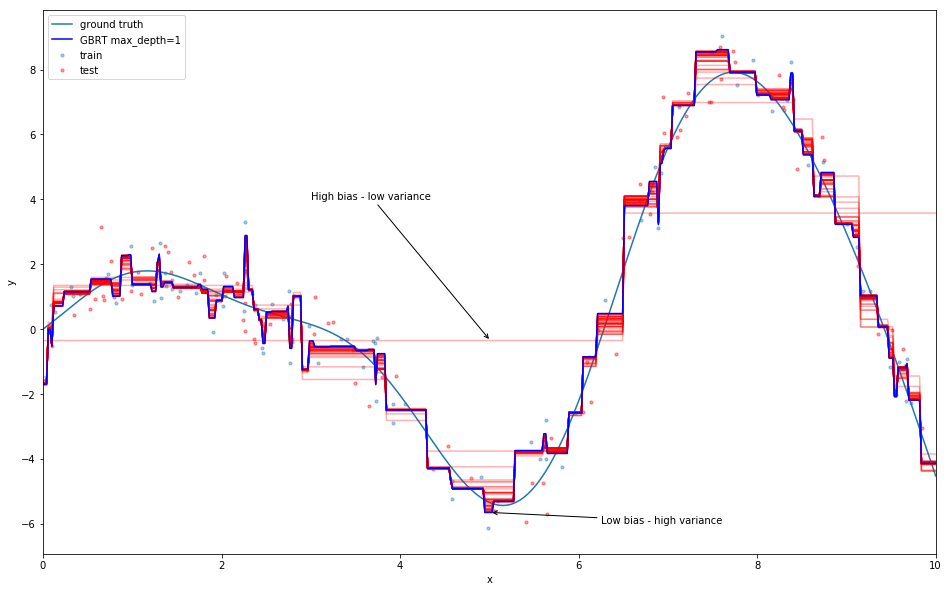

In [12]:
from itertools import islice

plot_data()

est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0)
est.fit(X_train, y_train)

ax = plt.gca()
first = True

# step over prediction as we added 20 more trees.
for pred in islice(est.staged_predict(x_plot[:, np.newaxis]), 0, 1000, 20):
    plt.plot(x_plot, pred, color='r', alpha=0.3)
    if first:
        ax.annotate('High bias - low variance', xy=(x_plot[x_plot.shape[0] // 2],
                                                    pred[x_plot.shape[0] // 2]),
                                                    xycoords='data',
                                                    xytext=(3, 4), textcoords='data',
                                                    arrowprops=dict(arrowstyle="->",
                                                                    connectionstyle="arc"))
        first = False

pred = est.predict(x_plot[:, np.newaxis])
plt.plot(x_plot, pred, color='b', label='GBRT max_depth=1')
ax.annotate('Low bias - high variance', xy=(x_plot[x_plot.shape[0] // 2],
                                            pred[x_plot.shape[0] // 2]),
                                            xycoords='data', xytext=(6.25, -6),
                                            textcoords='data', arrowprops=dict(arrowstyle="->",
                                                                               connectionstyle="arc"))
plt.legend(loc='upper left')
plt.show()

The above plot shows 50 red lines, each shows the response of the GBRT model after 20 trees have been added. It starts with a very crude approximation that can only fit more-or-less constant functions (ie. _High bias - low variance_) but as we add more trees the more variance our model can capture resulting in the solid red line.

We can see that the more trees we add to our GBRT model and the deeper the individual trees are the more variance we can capture thus the higher the complexity of our model. But as usual in machine learning model complexity comes at a price -- *overfitting*.

An important diagnostic when using GBRT in practise is the so-called *deviance plot* that shows the training/testing error (or deviance) as a function of the number of trees.

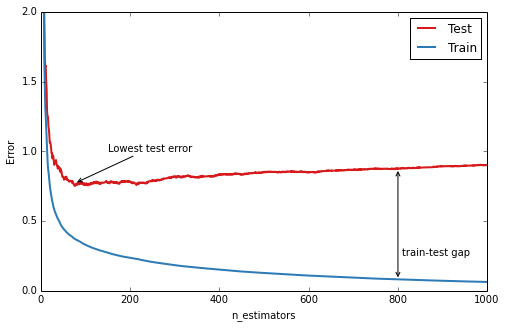

In [8]:
n_estimators = len(est.estimators_)

def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6', 
                  test_color='#d7191c', alpha=1.0):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
       test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize=(8, 5))
        ax = plt.gca()
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, 
             linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color, 
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim((0, 2))
    return test_dev, ax

test_dev, ax = deviance_plot(est, X_test, y_test)
ax.legend(loc='upper right')

# add some annotations
ax.annotate('Lowest test error', xy=(test_dev.argmin() + 1, test_dev.min() + 0.02), xycoords='data',
            xytext=(150, 1.0), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )

ann = ax.annotate('', xy=(800, test_dev[799]),  xycoords='data',
                  xytext=(800, est.train_score_[799]), textcoords='data',
                  arrowprops=dict(arrowstyle="<->"))
ax.text(810, 0.25, 'train-test gap')

The blue line above shows the training error: it rapidly decreases in the beginning and then gradually slows down but keeps decreasing as we add more and more trees. The testing error (red line) too decreases rapidly in the beginning but then slows down and reaches its minimum fairly early (~50 trees) and then even starts increasing.
This is what we call *overfitting*, at a certain point the model has so much capacity that it starts fitting the idiosyncrasies of the training data -- in our case the random gaussian noise component that we added -- and hence limiting its ability to generalize to new unseen data. A large gap between training and testing error is usually a sign of overfitting.

The great thing about gradient boosting is that it provides a number of knobs to control overfitting. These are usually subsummed by the term *regularization*.

### Regularization

GBRT provide three knobs to control overfitting: tree structure, shrinkage, and randomization.

#### Tree Structure

The depth of the individual trees is one aspect of model complexity. The depth of the trees basically control ***the degree of feature interactions*** that your model can fit. 

For example, if you want to capture the interaction between a feature ``latitude`` and a feature ``longitude`` your trees need a depth of at least two to capture this. Unfortunately, the degree of feature interactions is not known in advance but it is usually fine to assume that it is faily low -- in practise, a depth of 4-6 usually gives the best results. In scikit-learn you can constrain the depth of the trees using the ***``max_depth``*** argument.

Another way to control the depth of the trees is by enforcing a lower bound on the number of samples in a leaf: this will avoid inbalanced splits where a leaf is formed for just one extreme data point. In scikit-learn you can do this using the argument ***``min_samples_leaf``***. This is effectively a means to introduce bias into your model with the hope to also reduce variance as shown in the example below:

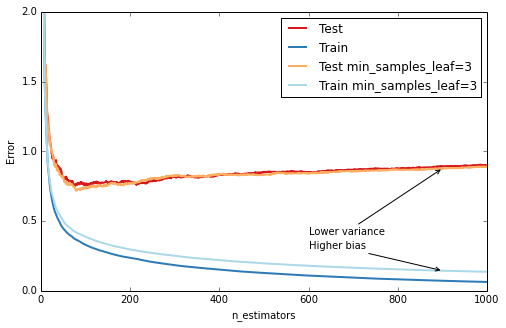

In [9]:
def fmt_params(params):
    return ", ".join("{0}={1}".format(key, val) for key, val in params.iteritems())

fig = plt.figure(figsize=(8, 5))
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'min_samples_leaf': 3},('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1, learning_rate=1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Higher bias', xy=(900, est.train_score_[899]), xycoords='data',
            xytext=(600, 0.3), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
ax.annotate('Lower variance', xy=(900, test_dev[899]), xycoords='data',
            xytext=(600, 0.4), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
plt.legend(loc='upper right')

#### Shrinkage

The most important regularization technique for GBRT is shrinkage: the idea is basically to do slow learning by shrinking the predictions of each individual tree by some small scalar, the ``learning_rate``. By doing so the model has to re-enforce concepts. A lower ``learning_rate`` requires a higher number of ``n_estimators`` to get to the same level of training error -- so its trading runtime against accuracy.

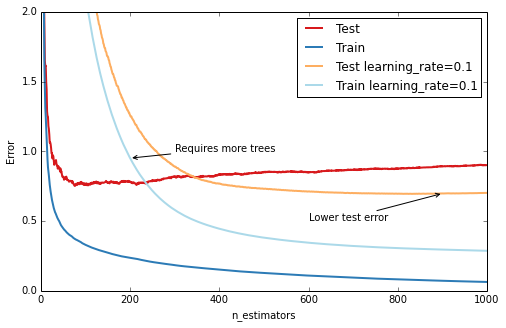

In [10]:
fig = plt.figure(figsize=(8, 5))
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'learning_rate': 0.1},
                                           ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1, learning_rate=1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Requires more trees', xy=(200, est.train_score_[199]), xycoords='data',
            xytext=(300, 1.0), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
ax.annotate('Lower test error', xy=(900, test_dev[899]), xycoords='data',
            xytext=(600, 0.5), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
plt.legend(loc='upper right')

#### Stochastic Gradient Boosting

Similar to ``RandomForest``, introducing randomization into the tree building process can lead to higher accuracy. Scikit-learn provides two ways to introduce randomization:<br>
a) subsampling the training set before growing each tree (***``subsample``***) and <br>
b) subsampling the features before finding the best split node (***``max_features``***).<br>
Experience showed that the latter works better if there is a sufficient large number of features (>30).
One thing worth noting is that both options reduce runtime.

Below we show the effect of using ``subsample=0.5``, ie. growing each tree on 50% of the training data,  on our toy example:

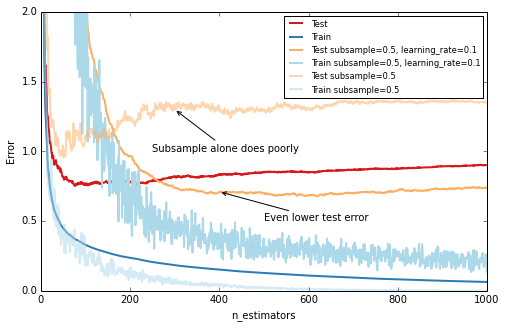

In [11]:
fig = plt.figure(figsize=(8, 5))
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'learning_rate': 0.1, 'subsample': 0.5},
                                           ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1, learning_rate=1.0,
                                    random_state=1)
    est.set_params(**params)
    est.fit(X_train, y_train)
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Even lower test error', xy=(400, test_dev[399]), xycoords='data',
            xytext=(500, 0.5), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )

est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1, learning_rate=1.0,
                                subsample=0.5)
est.fit(X_train, y_train)
test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params({'subsample': 0.5}),
                             train_color='#abd9e9', test_color='#fdae61', alpha=0.5)
ax.annotate('Subsample alone does poorly', xy=(300, test_dev[299]), xycoords='data',
            xytext=(250, 1.0), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
plt.legend(loc='upper right', fontsize='small')

### Hyperparameter tuning

We now have introduced a number of hyperparameters -- as usual in machine learning it is quite tedious to optimize them. Especially, since they interact with each other (``learning_rate`` and ``n_estimators``, ``learning_rate`` and ``subsample``, ``max_depth`` and ``max_features``).

We usually follow this recipe to tune the hyperparameters for a gradient boosting model:

  1. Choose ``loss`` based on your problem at hand (ie. target metric)
  2. Pick ``n_estimators`` as large as (computationally) possible (e.g. 3000).
  3. Tune ``max_depth``, ``learning_rate``, ``min_samples_leaf``, and ``max_features`` via grid search.
  4. Increase ``n_estimators`` even more and tune ``learning_rate`` again holding the other parameters fixed.
    
Scikit-learn provides a convenient API for hyperparameter tuning and grid search:

In [28]:
from sklearn.grid_search import GridSearchCV

param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9, 17],
              # 'max_features': [1.0, 0.3, 0.1] ## not possible in our example (only 1 fx)
              }

est = GradientBoostingRegressor(n_estimators=3000)
# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, n_jobs=4).fit(X_train, y_train)

# best hyperparameter setting
gs_cv.best_params_

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


{'learning_rate': 0.05, 'max_depth': 6, 'min_samples_leaf': 5}

## Use-case: California Housing

This use-case study shows how to apply GBRT to a real-world dataset. The task is to predict the log median house value for census block groups in California. The dataset is based on the 1990 censues comprising roughly 20.000 groups. There are 8 features for each group including: median income, average house age, latitude, and longitude.
To be consistent with [Hastie et al., *The Elements of Statistical Learning*, Ed2] we use Mean Absolute Error as our target metric and evaluate the results on an 80-20 train-test split.

In [2]:
import pandas as pd

In [ ]:
# you can download the data from sklearn
# from sklearn.datasets.california_housing import fetch_california_housing
# cal_housing = fetch_california_housing()
#you can load the data from local

In [ ]:


# split 80/20 train-test
X_train, X_test, y_train, y_test = train_test_split(cal_housing.data,
                                                    np.log(cal_housing.target),
                                                    test_size=0.2,
                                                    random_state=1)
names = cal_housing.feature_names
names

downloading Cal. housing from http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.tgz to C:\Users\Administrator\scikit_learn_data


Some of the aspects that make this dataset challenging are: 
- a) heterogenous features (different scales and distributions) and
- b) non-linear feature interactions (specifically latitude and longitude).
- Furthermore, the data contains some extreme values of the response (log median house value) -- such a dataset strongly benefits from robust regression techniques such as huberized loss functions.

Below you can see histograms for some of the features and the response. You can see that they are quite different: median income is left skewed, latitude and longitude are bi-modal, and log median house value is right skewed.

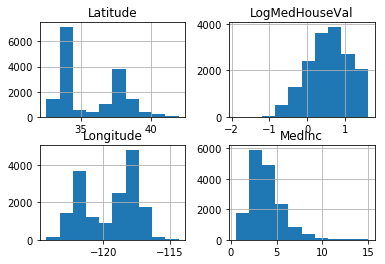

In [35]:
import pandas as pd
X_df = pd.DataFrame(data=X_train, columns=names)
X_df['LogMedHouseVal'] = y_train
_ = X_df.hist(column=['Latitude', 'Longitude', 'MedInc', 'LogMedHouseVal'])

Lets fit a GBRT model to this dataset and inspect the model

In [36]:
est = GradientBoostingRegressor(n_estimators=3000, max_depth=6, learning_rate=0.04,
                                loss='huber', random_state=0)
est.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.04, loss='huber', max_depth=6,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3000, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

In [37]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, est.predict(X_test))
print('MAE: %.4f' % mae)

MAE: 0.1452


### Feature importance

Often features do not contribute equally to predict the target response. When interpreting a model, the first question usually is: 
- what are those important features and how do they contributing in predicting the target response?

A GBRT model derives this information from the fitted regression trees which intrinsically perform feature selection by choosing appropriate split points. You can access this information via the instance attribute ``est.feature_importances_``.

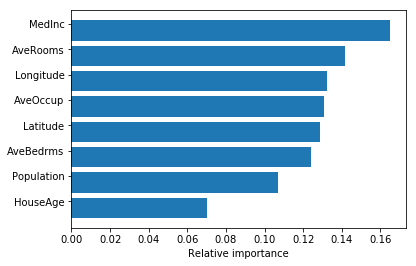

In [38]:
# sort importances
indices = np.argsort(est.feature_importances_)
# plot as bar chart
plt.barh(np.arange(len(names)), est.feature_importances_[indices])
plt.yticks(np.arange(len(names)) + 0.25, np.array(names)[indices])
_ = plt.xlabel('Relative importance')

### Partial dependence

Partial dependence plots show the dependence between the response and a set of features, marginalizing over the values of all other features. Intuitively, we can interpret the partial dependence as the expected response as a function of the features we conditioned on.

The plot below contains 4 one-way partial depencence plots (PDP) each showing the effect of an idividual feature on the repsonse. We can see that median income ``MedInc`` has a linear relationship with the log median house value.
The contour plot shows a two-way PDP. Here we can see an interesting feature interaction. It seems that house age itself has hardly an effect on the response but when ``AveOccup`` is small it has an effect (the older the house the higher the price).

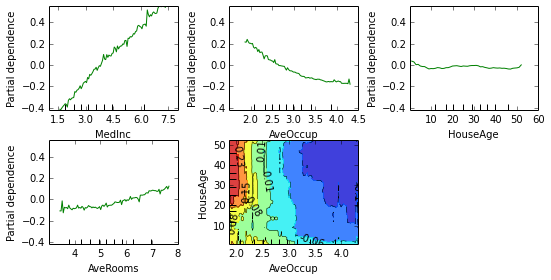

In [18]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

features = ['MedInc', 'AveOccup', 'HouseAge', 'AveRooms',
            ('AveOccup', 'HouseAge')]
fig, axs = plot_partial_dependence(est, X_train, features,
                                   feature_names=names, figsize=(8, 6))

Scikit-learn provides a convenience function to create such plots: ``sklearn.ensemble.partial_dependence.plot_partial_dependence`` or a low-level function that you can use to create custom partial dependence plots (e.g. map overlays or 3d plots). 
More detailed information can be found [here](http://scikit-learn.org/dev/modules/ensemble.html#partial-dependence).